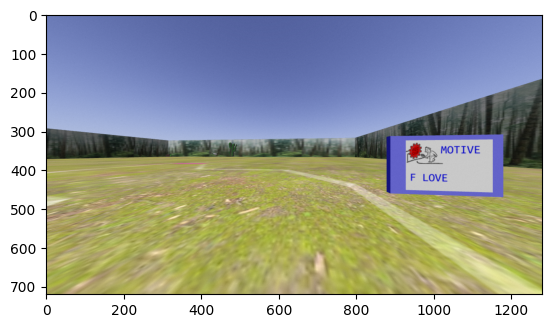

In [517]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# Load the image
image = cv2.imread('Clue_boards/test_1_20231126-223445.png')
# image = cv2.imread('stacked_image.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

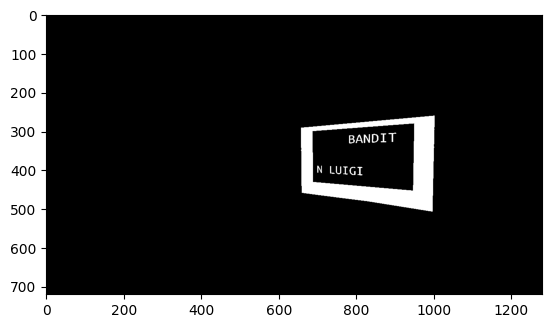

In [463]:
# Convert BGR to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

uh = 130
us = 255
uv = 255
lh = 118
ls = 103
lv = 85
lower_hsv = np.array([lh,ls,lv])
upper_hsv = np.array([uh,us,uv])

# Threshold the HSV image to get only blue colors
binary_image = cv2.inRange(hsv, lower_hsv, upper_hsv)

plt.imshow(binary_image, cmap='gray')

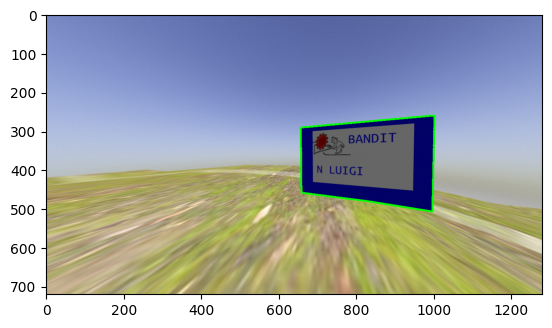

In [464]:
# Find Canny edges 
edged = cv2.Canny(binary_image, 30, 200)

# Finding Contours 
# Use a copy of the image e.g. edged.copy() 
# since findContours alters the image 
contours, hierarchy = cv2.findContours(edged,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

image_copy = image.copy()

board_cnt = []
for cnt in contours:
    if (len(cnt) > len(board_cnt)):
        board_cnt = cnt
cv2.drawContours(image_copy, board_cnt, -1, (0, 255, 0), 3)

plt.imshow(image_copy)

In [466]:
epsilon = 0.1 * cv2.arcLength(board_cnt, True)
approx_corners = cv2.approxPolyDP(board_cnt, epsilon, True)

# Check if we have four corners
if len(approx_corners) == 4:
    # Reshape for convenience
    points = approx_corners.reshape(4, 2)

    # Compute the centroid
    centroid = np.mean(points, axis=0)

    # Sort the points based on their relation to the centroid
    top = points[np.where(points[:, 1] < centroid[1])]
    bottom = points[np.where(points[:, 1] >= centroid[1])]

    sorted_points = np.zeros((4, 2), dtype=np.float32)

    sorted_points[0] = top[np.argmin(top[:, 0])]  # Top-left point has the smallest x value
    sorted_points[1] = top[np.argmax(top[:, 0])]  # Top-right point has the largest x value
    sorted_points[2] = bottom[np.argmax(bottom[:, 0])]  # Bottom-right point has the largest x value
    sorted_points[3] = bottom[np.argmin(bottom[:, 0])]  # Bottom-left point has the smallest x value

    # sorted_points now contains the corners in the order: top-left, top-right, bottom-right, bottom-left
else:
    print("The contour does not have four corners.")

top_left = sorted_points[0]
top_right = sorted_points[1]
bottom_right = sorted_points[2]
bottom_left = sorted_points[3]

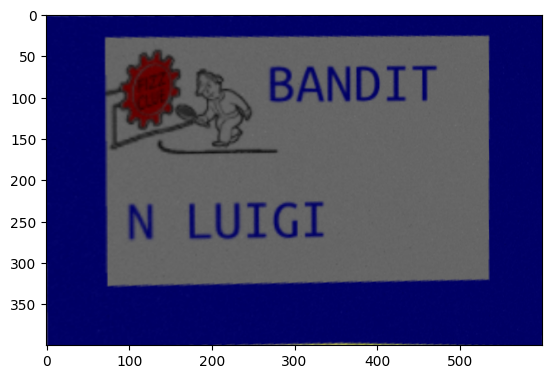

In [467]:
src_pts = np.float32([top_left, top_right, bottom_right, bottom_left])
width, height = 600, 400
dst_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Apply the perspective transformation
warped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(warped_image)

(69, 26)
(536, 23)
(538, 322)
(71, 329)


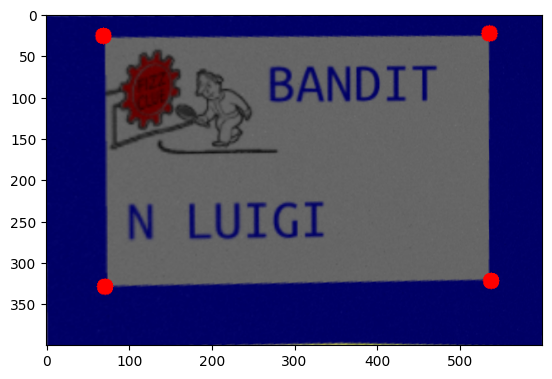

In [468]:
# Apply Harris Corner Detector
block_size = 5
aperture_size = 5
k = 0.08
harris_corners = cv2.cornerHarris(warped_image[:, :, 0], block_size, aperture_size, k)

# Dilate the corner points to enhance them
harris_corners = cv2.dilate(harris_corners, None)

# Threshold for an optimal value, identify strong corners
threshold = 0.01 * harris_corners.max()

corners = []

# Draw solid red circles on each corner
for y in range(harris_corners.shape[0]):
    for x in range(harris_corners.shape[1]):
        if harris_corners[y, x] > threshold:
            # Eliminate bad corners lcoated close to the edges of the image
            cond_0 = x >= 10 and x <= 590
            cond_1 = y >= 10 and y <= 390
            if cond_0 and cond_1:
                corners.append((x, y))

top_left, top_right, bottom_right, bottom_left = find_corners(corners)

for x, y in top_left, top_right, bottom_right, bottom_left:
    print((x, y))
    cv2.circle(warped_image, (x, y), 10, (255, 0, 0), -1)

plt.imshow(warped_image, cmap='gray')

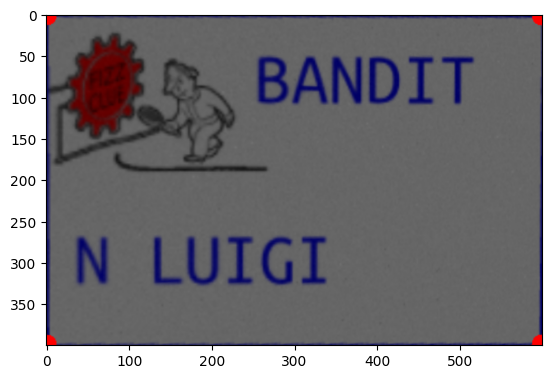

In [469]:
src_pts = np.float32([top_left, top_right, bottom_right, bottom_left])
width, height = 600, 400
dst_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Apply the perspective transformation
warped_image = cv2.warpPerspective(warped_image, M, (width, height))

plt.imshow(warped_image)

(102, 30)
(553, 28)
(555, 376)
(111, 386)


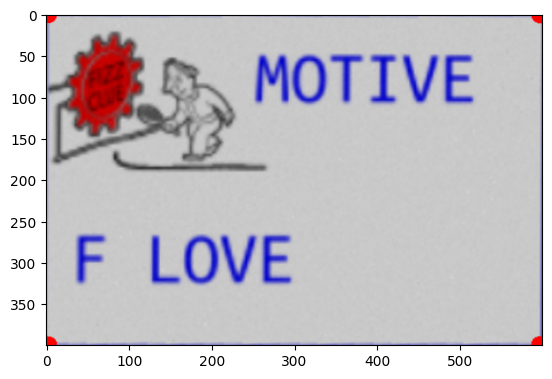

In [518]:
def find_corners(corners):
        # Initialize corners with the first point in the list
        top_left = top_right = bottom_right = bottom_left = corners[0]

        for x, y in corners:
            if x + y < top_left[0] + top_left[1]:
                top_left = (x, y)
            if x - y > top_right[0] - top_right[1]:
                top_right = (x, y)
            if x + y > bottom_right[0] + bottom_right[1]:
                bottom_right = (x, y)
            if x - y < bottom_left[0] - bottom_left[1]:
                bottom_left = (x, y)

        return top_left, top_right, bottom_right, bottom_left

def distance(p1, p2):
    """Calculate the distance between two points."""
    return ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5

def angle(p1, p2, p3):
    """Calculate the angle at p2 formed by the line segments p1-p2 and p2-p3."""
    a = distance(p2, p1)
    b = distance(p2, p3)
    c = distance(p1, p3)
    return math.acos((a**2 + b**2 - c**2) / (2 * a * b)) * (180 / math.pi)

def is_rectangle(tl, tr, br, bl):
    """Check if the points form a rectangle."""
    # Check the distances of opposite sides
    top_length = distance(tl, tr)
    bottom_length = distance(bl, br)
    left_length = distance(tl, bl)
    right_length = distance(tr, br)

    # if not (math.isclose(top_length, bottom_length) and math.isclose(left_length, right_length)):
    #     return False

    # Check the angles
    angles = [
        angle(tl, tr, br),
        angle(tr, br, bl),
        angle(br, bl, tl),
        angle(bl, tl, tr)
    ]
    return all(80 <= a <= 100 for a in angles)  # Allowing some tolerance

def identify_clue(image):
    # Return this black image if no clues found
    height = 400
    width = 600
    black_image = np.zeros((height, width, 3), dtype=np.uint8)

    ## Color thresholding
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    uh = 130
    us = 255
    uv = 255
    lh = 118
    ls = 103
    lv = 85
    lower_hsv = np.array([lh,ls,lv])
    upper_hsv = np.array([uh,us,uv])

    # Threshold the HSV image to get only blue colors
    binary_image = cv2.inRange(hsv, lower_hsv, upper_hsv)

    ## Find contour
    # Find Canny edges 
    edged = cv2.Canny(binary_image, 30, 200)
    contours, hierarchy = cv2.findContours(edged,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 0:
        return black_image

    # image_copy = image.copy()

    board_cnt = []
    for cnt in contours:
        if (len(cnt) > len(board_cnt)):
            board_cnt = cnt
    # cv2.drawContours(image_copy, board_cnt, -1, (0, 255, 0), 3)
    if len(board_cnt) <= 500:
        return black_image

    ## Find edges in contour
    epsilon = 0.1 * cv2.arcLength(board_cnt, True)
    approx_corners = cv2.approxPolyDP(board_cnt, epsilon, True)

    # Check if we have four corners
    if len(approx_corners) == 4:
        # Reshape for convenience
        points = approx_corners.reshape(4, 2)

        # Compute the centroid
        centroid = np.mean(points, axis=0)

        # Sort the points based on their relation to the centroid
        top = points[np.where(points[:, 1] < centroid[1])]
        bottom = points[np.where(points[:, 1] >= centroid[1])]

        sorted_points = np.zeros((4, 2), dtype=np.float32)

        sorted_points[0] = top[np.argmin(top[:, 0])]  # Top-left point has the smallest x value
        sorted_points[1] = top[np.argmax(top[:, 0])]  # Top-right point has the largest x value
        sorted_points[2] = bottom[np.argmax(bottom[:, 0])]  # Bottom-right point has the largest x value
        sorted_points[3] = bottom[np.argmin(bottom[:, 0])]  # Bottom-left point has the smallest x value

        # sorted_points now contains the corners in the order: top-left, top-right, bottom-right, bottom-left
    else:
        return black_image

    top_left = sorted_points[0]
    top_right = sorted_points[1]
    bottom_right = sorted_points[2]
    bottom_left = sorted_points[3]

    ## First perspective transform
    src_pts = np.float32([top_left, top_right, bottom_right, bottom_left])
    width, height = 600, 400
    dst_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Apply the perspective transformation
    warped_image = cv2.warpPerspective(image, M, (width, height))

    ## Locate corners again
    # Apply Harris Corner Detector
    block_size = 5
    aperture_size = 5
    k = 0.08
    harris_corners = cv2.cornerHarris(warped_image[:, :, 0], block_size, aperture_size, k)

    # Dilate the corner points to enhance them
    harris_corners = cv2.dilate(harris_corners, None)

    # Threshold for an optimal value, identify strong corners
    threshold = 0.01 * harris_corners.max()

    corners = []

    # Draw solid red circles on each corner
    for y in range(harris_corners.shape[0]):
        for x in range(harris_corners.shape[1]):
            if harris_corners[y, x] > threshold:
                # Eliminate bad corners lcoated close to the edges of the image
                cond_0 = x >= 10 and x <= 590
                cond_1 = y >= 10 and y <= 390
                if cond_0 and cond_1:
                    corners.append((x, y))
    if (len(corners) < 4):
        return black_image

    top_left, top_right, bottom_right, bottom_left = find_corners(corners)

    # def isRect(top_left, top_right, bottom_right, bottom_left):
    #     cx = (top_left[0] + top_right[0] + bottom_right[0] + bottom_left[0]) / 4
    #     cy = (top_left[1] + top_right[1] + bottom_right[1] + bottom_left[1]) / 4

    #     dd1 = np.sqrt(np.abs(cx - top_left[0])) + np.sqrt(np.abs(cy - top_left[1]))
    #     dd2 = np.sqrt(np.abs(cx - top_right[0])) + np.sqrt(np.abs(cy - top_right[1]))
    #     dd3 = np.sqrt(np.abs(cx - bottom_right[0])) + np.sqrt(np.abs(cy - bottom_right[1]))
    #     dd4 = np.sqrt(np.abs(cx - bottom_left[0])) + np.sqrt(np.abs(cy - bottom_left[1]))
        
    #     cond_0 = np.abs(dd1 - dd2) <= 5
    #     cond_1 = np.abs(dd1 - dd3) <= 5
    #     cond_2 = np.abs(dd1 - dd4) <= 5

    #     return cond_0 and cond_1 and cond_2

    if (is_rectangle(top_left, top_right, bottom_right, bottom_left) == False):
        return black_image

    for x, y in top_left, top_right, bottom_right, bottom_left:
        print((x, y))
        cv2.circle(warped_image, (x, y), 10, (255, 0, 0), -1)
    
    ## Second perspective transform
    src_pts = np.float32([top_left, top_right, bottom_right, bottom_left])
    width, height = 600, 400
    dst_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Apply the perspective transformation
    warped_image = cv2.warpPerspective(warped_image, M, (width, height))

    return warped_image

result = identify_clue(image)
plt.imshow(result)

In [514]:
input_vid_path = 'dashcam_full.avi'
output_vid_path = 'dashcam_out.avi'

cap = cv2.VideoCapture(input_vid_path)
vid = cv2.VideoWriter_fourcc(*'MJPG')

# The output frame size will be the width of frame + width of clue, and the height of frame
output_size = (1280 + 600, 720)  
out = cv2.VideoWriter(output_vid_path, vid, 10.0, output_size)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Assuming identify_clue returns a 600x400 image
    clue = identify_clue(frame)
    # clue = cv2.cvtColor(clue, cv2.COLOR_HSV2RGB)

    # Calculate the required padding
    top_bottom_padding = (720 - 400) // 2

    # Create a black background that matches the frame's height
    background = np.zeros((720, 600, 3), dtype=np.uint8)

    # Place the clue image in the middle of the black background
    background[top_bottom_padding:top_bottom_padding + 400, :] = clue

    # Create a new frame to hold both images
    combined_frame = np.zeros((720, 1280 + 600, 3), dtype=np.uint8)

    # Place the original frame on the left
    combined_frame[:, :1280] = frame

    # Place the padded clue image on the right
    combined_frame[:, 1280:] = background
    combined_frame = cv2.cvtColor(combined_frame, cv2.COLOR_RGB2BGR)

    out.write(combined_frame)

# Release the video object
cap.release()
out.release()

(60, 16)
(506, 33)
(505, 375)
(50, 380)
(45, 30)
(492, 24)
(501, 378)
(48, 379)
(41, 22)
(487, 26)
(482, 390)
(36, 378)
(10, 76)
(424, 32)
(424, 372)
(14, 310)
(10, 76)
(457, 32)
(457, 371)
(10, 308)
(24, 63)
(292, 19)
(302, 274)
(27, 304)
(58, 53)
(372, 48)
(387, 324)
(15, 324)
(30, 53)
(439, 49)
(448, 325)
(47, 322)
(10, 57)
(337, 49)
(352, 323)
(13, 326)
(278, 30)
(285, 30)
(287, 369)
(276, 368)
(127, 65)
(548, 36)
(547, 373)
(125, 312)
(104, 31)
(546, 27)
(545, 379)
(96, 380)
(109, 25)
(555, 31)
(551, 374)
(106, 382)
(111, 27)
(556, 29)
(560, 374)
(114, 382)
(173, 30)
(181, 30)
(187, 370)
(176, 370)
(65, 20)
(519, 29)
(514, 374)
(57, 371)
(65, 24)
(522, 28)
(520, 381)
(63, 380)
(67, 10)
(521, 32)
(517, 369)
(64, 371)
(63, 24)
(515, 28)
(511, 383)
(57, 372)
(49, 31)
(507, 28)
(512, 377)
(58, 378)
(46, 29)
(502, 26)
(511, 374)
(50, 377)
(51, 22)
(497, 26)
(499, 385)
(51, 380)
(48, 21)
(495, 27)
(498, 386)
(45, 379)
(48, 21)
(498, 26)
(498, 386)
(46, 380)
(72, 32)
(534, 17)
(537, 315)

In [ ]:
# input_vid_path = 'test_cctv_720p.mov'
# output_vid_path = 'dashcam_out_optical_flow.avi'

# cap = cv2.VideoCapture(input_vid_path)
# vid = cv2.VideoWriter_fourcc(*'MJPG')
# out = cv2.VideoWriter(output_vid_path, vid, 30.0, (1280 * 2, 720))

# # ret = a boolean return value from 
# # getting the frame, first_frame = the 
# # first frame in the entire video sequence 
# ret, first_frame = cap.read()
# print(first_frame.shape)
  
# # Converts frame to grayscale because we 
# # only need the luminance channel for 
# # detecting edges - less computationally  
# # expensive 
# prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) 
  
# # Creates an image filled with zero 
# # intensities with the same dimensions  
# # as the frame 
# mask = np.zeros_like(first_frame) 
  
# # Sets image saturation to maximum 
# mask[..., 1] = 255

# while True:
#   ret, frame = cap.read()

#   if ret == False:
#     break

#   # Converts each frame to grayscale - we previously  
#   # only converted the first frame to grayscale 
#   gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
    
#   # Calculates dense optical flow by Farneback method 
#   flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,  
#                                       None, 
#                                       0.5, 3, 15, 3, 5, 1.2, 0) 
    
#   # Computes the magnitude and angle of the 2D vectors 
#   magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
    
#   # Sets image hue according to the optical flow  
#   # direction 
#   mask[..., 0] = angle * 180 / np.pi / 2
    
#   # Sets image value according to the optical flow 
#   # magnitude (normalized) 
#   mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) 
    
#   # Converts HSV to RGB (BGR) color representation 
#   rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

#   # Combine input frame (left) with output frame (right)
#   combined_frame = np.hstack((frame, rgb))

#   out.write(combined_frame)

#   # Updates previous frame 
#   prev_gray = gray
  
# # Release the video object
# cap.release()
# out.release()

In [ ]:
def highlight_text(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Polygon corner points coordinates
    letter_width = 45
    letter_height = 70
    w_0 = 6 * letter_width
    h_0 = letter_height
    w_1 = 12 * letter_width
    h_1 = letter_height
    pts_0 = np.array([[250, 40], [250, 40 + h_0], [250 + w_0, 40 + h_0], [250 + w_0, 40],], np.int32)
    pts_1 = np.array([[30, 260], [30, 260 + h_1], [30 + w_1, 260 + h_1], [30 + w_1, 260],], np.int32)
    img = cv2.polylines(img, [np.int32(pts_0)], True, (0, 255, 0), 3)
    img = cv2.polylines(img, [np.int32(pts_1)], True, (0, 255, 0), 3)
    return img

(400, 600, 3)


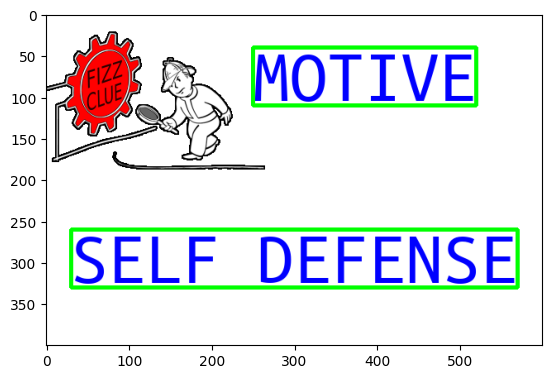

In [ ]:
# Figure out the coordinates of the texts in clue board
img = cv2.imread('unlabelled/plate_MOTIVE_SELF DEFENSE.png')
print(img.shape)
img = highlight_text(img)

plt.imshow(img)

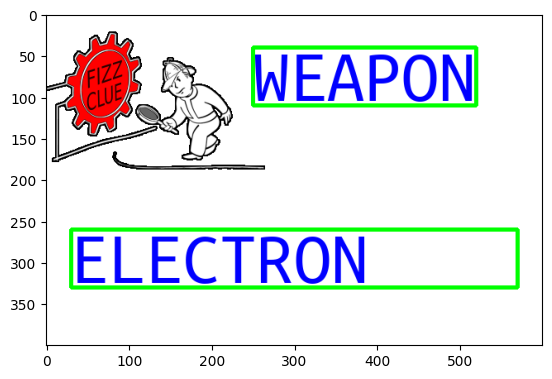

In [ ]:
# Figure out the coordinates of the texts in clue board
img = cv2.imread('unlabelled/plate_WEAPON_ELECTRON.png')
img = highlight_text(img)

plt.imshow(img)

## Data augmentation

In [ ]:
import os
import random

def apply_gaussian_blur(image):
    """ Apply Gaussian Blur with a random kernel size """
    kernel_size = random.choice([(3, 3), (5, 5), (7, 7)])
    return cv2.GaussianBlur(image, kernel_size, 0)

def apply_box_blur(image):
    # kernel_size = random.randint(3, 10)
    kernel_size = 10
    kernel = np.ones((kernel_size, kernel_size), np.float32) / kernel_size**2
    image = cv2.filter2D(image, -1, kernel)
    return image

def apply_motion_blur(image):
    """ Apply Motion Blur with a random kernel size and direction """
    kernel_size = random.choice([5, 10, 15])
    # Randomly choose the direction of motion blur
    direction = random.choice(['horizontal', 'vertical', 'diagonal'])

    kernel = np.zeros((kernel_size, kernel_size))

    if direction == 'horizontal':
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    elif direction == 'vertical':
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    elif direction == 'diagonal':
        np.fill_diagonal(kernel, 1)

    kernel = kernel / kernel_size
    return cv2.filter2D(image, -1, kernel)

def change_illuminance(image):
    """ Change the illuminance of the image with random alpha and beta to slightly darken the image """
    alpha = random.uniform(0.5, 1.2)  # Reduced contrast control
    beta = random.randint(-70, -30)    # Brightness control, leaning towards darkening
    new_image = np.clip(alpha * image + beta, 0, 255).astype(np.uint8)
    return new_image

def apply_warping(image):
    height, width = image.shape[:2]

    # Source points (corners of the image)
    src_pts = np.float32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]])

    # Small shifts and tilt factor
    shift_factor_x = random.uniform(-0.02, 0.02)
    shift_factor_y = random.uniform(-0.02, 0.02)
    shift_x, shift_y = width * shift_factor_x, height * shift_factor_y
    tilt_factor_x = random.uniform(-0.03, 0.03)  # Adjust this for more or less tilt
    tilt_factor_y = random.uniform(-0.03, 0.03)  # Adjust this for more or less tilt
    
    dst_pts = np.float32([
        [shift_x - width * tilt_factor_x, shift_y],
        [width-1 - shift_x + width * tilt_factor_x, shift_y - height * tilt_factor_y],
        [width-1 - shift_x, height-1 - shift_y + height * tilt_factor_y],
        [shift_x, height-1 - shift_y]
    ])

    # Get the transformation matrix and apply it
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_image = cv2.warpPerspective(image, M, (width, height))
    return warped_image

def apply_rotation(image):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    angle = random.uniform(-1.5, 1.5)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def enhance_img(img):
    # img = apply_gaussian_blur(img)
    img = apply_box_blur(img)
    # img = apply_motion_blur(img)
    img = change_illuminance(img)
    img = apply_warping(img)
    img = apply_rotation(img)
    return img

In [ ]:
img = cv2.imread('unlabelled/plate_BANDIT_BARBIE.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = enhance_img(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = highlight_text(img)
plt.imshow(img)

NameError: name 'highlight_text' is not defined

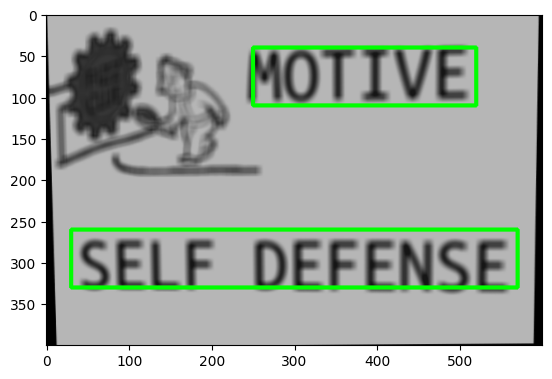

In [ ]:
img = cv2.imread('unlabelled/plate_MOTIVE_SELF DEFENSE.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = enhance_img(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = highlight_text(img)
plt.imshow(img)

In [ ]:
# # Directory path
# directory = "test_data"

# # Check if the directory exists
# if os.path.exists(directory):
#     print(f"Files in '{directory}' and its subdirectories:")

#     # Walk through directory and subdirectories
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             # Join the root directory path with the file name
#             full_path = os.path.join(root, file)
            
#             if (full_path.endswith('png')):
#                 img = cv2.imread(full_path)
#                 for i in range(10):
#                     img_enhanced = enhance_img(img)
#                     name_part, extension = full_path.rsplit('.', 1)
#                     full_path_enhanced = f"{name_part}_{i}.{extension}"
#                     cv2.imwrite(full_path_enhanced, img_enhanced)
            
# else:
#     print(f"The directory '{directory}' does not exist.")

In [ ]:
import cv2
import os
import numpy as np

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def stack_images(images, rows, cols):
    # Assuming all images are of the same size
    h, w, _ = images[0].shape
    grid = []
    
    for r in range(rows):
        row_imgs = images[r*cols:(r+1)*cols]
        row_imgs = [cv2.resize(img, (1280, 720)) for img in row_imgs]  # Resize if not 720p
        grid.append(np.hstack(row_imgs))

    return np.vstack(grid)

folder_path = 'clue_boards'  # Update this to your folder path
images = load_images_from_folder(folder_path)

# Check if the number of images is correct
if len(images) == 8:
    result_img = stack_images(images, 2, 4)
    cv2.imwrite('stacked_image.jpg', result_img)
    print("Image stacked and saved.")
else:
    print(f"Expected 8 images, but found {len(images)}.")

Image stacked and saved.
